In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
detection = fits.open('/home/aalvarez/Work/Data/sim08/sim08_i.fits')[0]
measure = fits.open('/home/aalvarez/Work/Data/sim08/sim08_i_03.fits')[0]

dwcs = WCS(detection.header)
mwcs = WCS(measure.header)

min_pixel = dwcs.all_world2pix(mwcs.all_pix2world([[0,0]],0), 0)[0]
max_pixel = dwcs.all_world2pix(mwcs.all_pix2world([[0,measure.data.shape[1]]],0), 0)[0]

In [3]:
min_pixel

array([1087.96191665, 1705.65289896])

In [4]:
def jacobian(dwcs, mwcs, x, y, w, h):
    cx = x + w / 2.
    cy = y + h / 2.
    origin = mwcs.all_world2pix(dwcs.all_pix2world([[cx, cy]], 0), 0)[0]
    dx = mwcs.all_world2pix(dwcs.all_pix2world([[cx+1., cy]], 0), 0)[0]
    dy = mwcs.all_world2pix(dwcs.all_pix2world([[cx, cy+1.]], 0), 0)[0]
    
    return np.asarray([
        [dx[0] - origin[0], dx[1] - origin[1]],
        [dy[0] - origin[0], dy[1] - origin[1]]
    ])

In [5]:
j = jacobian(dwcs, mwcs, 0, 0, measure.data.shape[0], measure.data.shape[1])
j

array([[-0.215386  ,  0.92034029],
       [ 0.92217834,  0.21754505]])

In [6]:
jr = np.linalg.inv(j)
jr

array([[-0.2429113 ,  1.02765405],
       [ 1.02970642,  0.24050049]])

In [7]:
np.dot(jr, [0, 1000])

array([1027.65405257,  240.50049492])

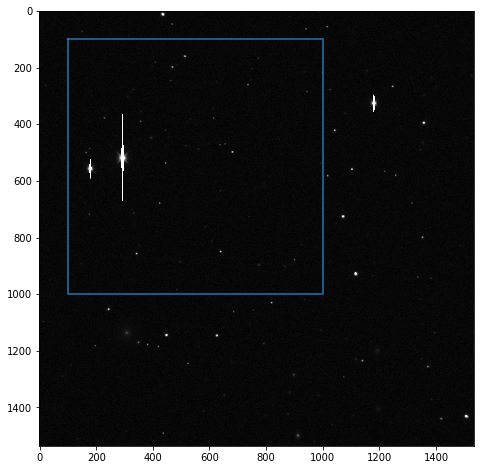

In [8]:
op=np.array([
    [100,  100],
    [100,  1000],
    [1000, 1000],
    [1000, 100],
    [100,  100],
])

plt.figure(figsize=(8,8))
plt.imshow(measure.data, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(10))
plt.plot(op[:,0], op[:,1])

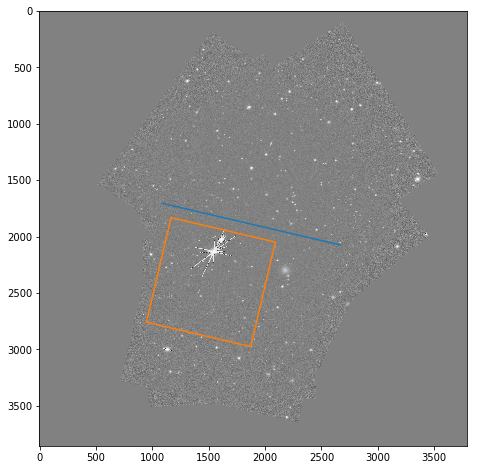

In [9]:
t = []
for o in op:
    t.append(np.dot(jr, o) + min_pixel)
t = np.array(t)

plt.figure(figsize=(8,8))
plt.imshow(detection.data, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(100))
plt.plot([min_pixel[0], max_pixel[0]], [min_pixel[1], max_pixel[1]])
plt.plot(t[:,0], t[:,1])

In [10]:
def f(x, y, xx=1, yy=1, xy=1):
    return xx * x**2 + yy * y**2 + xy * x*y

def ellipse(size, xx=1, yy=1, xy=1, limit=64, transform=None):
    a = np.zeros((size,size))
    for y in range(size):
        for x in range(size):
            if transform:
                vx,vy=transform(x-size/2,y-size/2)
            else:
                vx, vy = x-size/2, y-size/2
            a[x,y]=f(vx,vy, xx, yy, xy)
            if a[x,y] > limit:
                a[x,y] = 0
            else:
                a[x,y] = 1
    return a

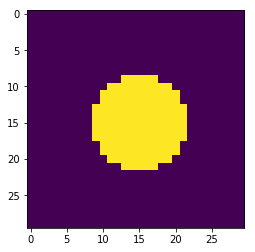

In [11]:
plt.figure()
plt.imshow(ellipse(30, xx=1.5, yy=1.5, xy=0))

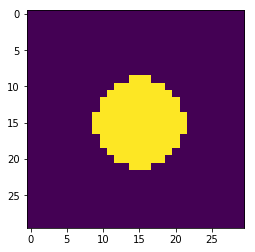

In [12]:
plt.figure()
plt.imshow(ellipse(30, 1.5, 1.5, 0, transform=lambda x,y: np.dot(jr, [x,y])))

In [13]:
print((np.dot(jr,[1, 0])**2).sum())
print((np.dot(jr,[0, 1])**2).sum())

1.1193012082011178
1.1139133398301566
